In [21]:
%load_ext autoreload
%autoreload 2
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalLSTMTSScoreMatching import ConditionalLSTMTSScoreMatching
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalLSTMTSPostMeanScoreMatching import ConditionalLSTMTSPostMeanScoreMatching

#from configs.RecursiveVPSDE.LSTM_fSin.recursive_PostMeanScaledScore_fSin_T256_H05_tl_5data import get_config as get_config
from configs.RecursiveVPSDE.LSTM_fSin.recursive_PostMeanScore_fSin_T256_H05_tl_5data import get_config as get_config
#from configs.RecursiveVPSDE.LSTM_fSin.recursive_fSinWithPosition_T256_H05_tl_5data import get_config as get_config

from configs import project_config
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
config = get_config()
print(config.beta_min)
print(config.max_diff_steps)
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")

diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

max_diff_steps = config.max_diff_steps
sample_eps = config.sample_eps
ts_step = 1 / config.ts_length

Nepoch = 960#config.max_epochs[0]
# Fix the number of training epochs and training loss objective loss

0.0
10000
Using CPU



In [33]:
import pickle
with open("/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/training_losses/trained_rec_markv_TSM_False_incs_True_unitIntv_fSin_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin00000e+00_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_10_tl5_Small_loss", 'rb') as f:
        losses_small = np.array(pickle.load(f))
with open("/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/training_losses/trained_rec_markv_TSM_False_incs_True_unitIntv_fSin_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin00000e+00_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_10_tl5_loss", "rb") as f:
    losses = np.array(pickle.load(f))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/training_losses/trained_rec_markv_TSM_False_incs_True_unitIntv_fSin_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin00000e+00_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_10_tl5_Small_loss'

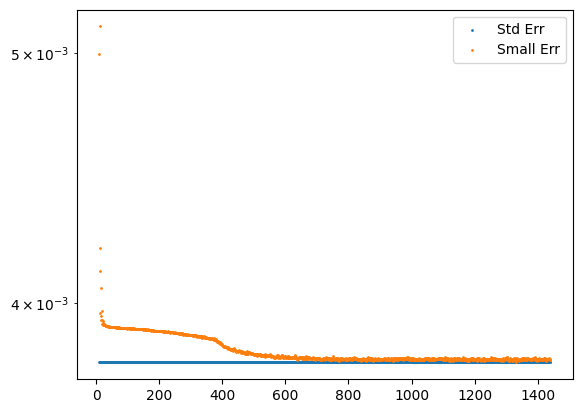

In [31]:
plt.scatter(np.arange(100, losses.shape[0]), losses[100:],s=1, label="Std Err")
plt.scatter(np.arange(100, losses_small.shape[0]), losses_small[100:], s=1,label="Small Err")
plt.legend()
plt.yscale("log")

In [13]:
Ndiff = config.max_diff_steps
if "PMS" in config.scoreNet_trained_path:
    type = "PMS"
    scoreModel = ConditionalLSTMTSPostMeanScoreMatching(
        *config.model_parameters)
elif "PM" in config.scoreNet_trained_path:
    type = "PM"
    scoreModel = ConditionalLSTMTSPostMeanScoreMatching(
        *config.model_parameters)
else:
    type = ""
    scoreModel = ConditionalLSTMTSScoreMatching(*config.model_parameters)
scoreModel.load_state_dict(torch.load(config.scoreNet_trained_path + "_NEp" + str(Nepoch)))
print(type)

PM


In [21]:
from tqdm import tqdm

def single_time_sampling(config, data_shape, diff_time_space, diffusion, feature, scoreModel, device, es
                         ):
    Xs = []
    x = diffusion.prior_sampling(shape=data_shape).to(device)  # Move to correct device
    Xs.append(x)
    for diff_index in tqdm(range(config.max_diff_steps)):
        if diff_index <= config.max_diff_steps - es - 1:
            tau = diff_time_space[diff_index] * torch.ones((data_shape[0],)).to(device)
            try:
                scoreModel.eval()
                with torch.no_grad():
                    tau = tau * torch.ones((x.shape[0],)).to(device)
                    predicted_score = scoreModel.forward(x, conditioner=feature, times=tau)
            except TypeError:
                scoreModel.eval()
                with torch.no_grad():
                    tau = tau * torch.ones((x.shape[0],)).to(device)
                    eff_times = diffusion.get_eff_times(diff_times=tau)
                    eff_times = eff_times.reshape(x.shape)
                    predicted_score = scoreModel.forward(x, conditioner=feature, times=tau, eff_times=eff_times)

            _, drift, diffParam = diffusion.get_conditional_reverse_diffusion(x=x,
                                                                              predicted_score=predicted_score,
                                                                              diff_index=torch.Tensor(
                                                                                  [int(diff_index)]).to(device),
                                                                              max_diff_steps=config.max_diff_steps)
            z = torch.randn_like(drift)
            x = drift + diffParam * z
            Xs.append(x)
        else:
            return x
    return x, Xs

def run_whole_ts_recursive_diffusion(config, ts_length, initial_feature_input, diffusion, scoreModel, device,
                                     diff_time_scale, data_shape, es):
    paths = []
    cumsamples = initial_feature_input
    for t in (range(ts_length)):
        paths.append(cumsamples.cpu())
        print("Sampling at real time {}\n".format(t + 1))
        scoreModel.eval()
        with torch.no_grad():
            if t == 0:
                feature, (h, c) = scoreModel.rnn(initial_feature_input, None)
            else:
                feature, (h, c) = scoreModel.rnn(cumsamples, (h, c))
        new_samples, Xs = single_time_sampling(config=config, data_shape=data_shape,
                                           diff_time_space=diff_time_scale,
                                           diffusion=diffusion, scoreModel=scoreModel,
                                           device=device, feature=feature,
                                           es=es)
        cumsamples = cumsamples + new_samples
    paths.append(cumsamples.cpu())
    paths = torch.concat(paths, dim=1).squeeze(-1)
    Zs =torch.concat(Xs, dim=1)
    return paths.cpu(), Zs


In [22]:
print(Nepoch, config.data_path, es, config.scoreNet_trained_path)

num_simulated_paths = 10000
data_shape = (num_simulated_paths, 1, 1)

revDiff_time_scale = torch.linspace(start=config.end_diff_time, end=config.sample_eps,
                                    steps=config.max_diff_steps).to(device)
diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

# Fix the number of real times to run diffusion
eval_ts_length = 1
# Experiment for score model with fixed (Nepochs, loss scaling, drift eval time, Npaths simulated)
initial_feature_input = torch.zeros(data_shape).to(device)
paths, Zs = run_whole_ts_recursive_diffusion(
    ts_length=eval_ts_length, config=config, initial_feature_input=initial_feature_input, diffusion=diffusion,
    scoreModel=scoreModel, device=device, diff_time_scale=revDiff_time_scale, data_shape=data_shape, es=40)


960 /Users/marcos/GitHubRepos/FractionalBrownianMotion/data/fSin_samples_H05_T256_10Rev_10Diff_00Init.npy 40 /Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_PM_TSM_False_incs_True_unitIntv_fSin_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin00000e+00_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_10_tl5
Sampling at real time 1



100%|█████████▉| 9960/10000 [33:13<00:08,  5.00it/s]  


ValueError: too many values to unpack (expected 2)

In [18]:
paths

torch.Size([10000, 2])